## Imports

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import missingno as msno  # Added for visualizing missing data

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Functions
from utils import plot_radar,regression_imputation,combine_imputed_column

## Data 

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

| Feature | Description |
|---------|-------------|
| Pregnancies   | Number of times pregnant       |
| Glucose   | Plasma glucose concentration a 2 hours in an oral glucose tolerance test       |
| BloodPressure  | Diastolic blood pressure (mm Hg)      |
| SkinThickness   | Triceps skin fold thickness (mm)       |
| Insulin   | 2-Hour serum insulin (mu U/ml)       |
| BMI   | Body mass index (weight in kg/(height in m)^2)       |
| DiabetesPedigreeFunction   | Diabetes pedigree function       |
| Age   | Age (years)      |
| Outcome(Has Diabetes)   | Class variable (0(False) or 1(True))        |


### Importing Data

In [2]:
dataset = np.loadtxt('data/pima-indians-diabetes.csv', delimiter=',')

cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
df = pd.DataFrame(dataset,columns=cols)


X = dataset[:,0:8]
y = dataset[:,8]
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


### Missing values

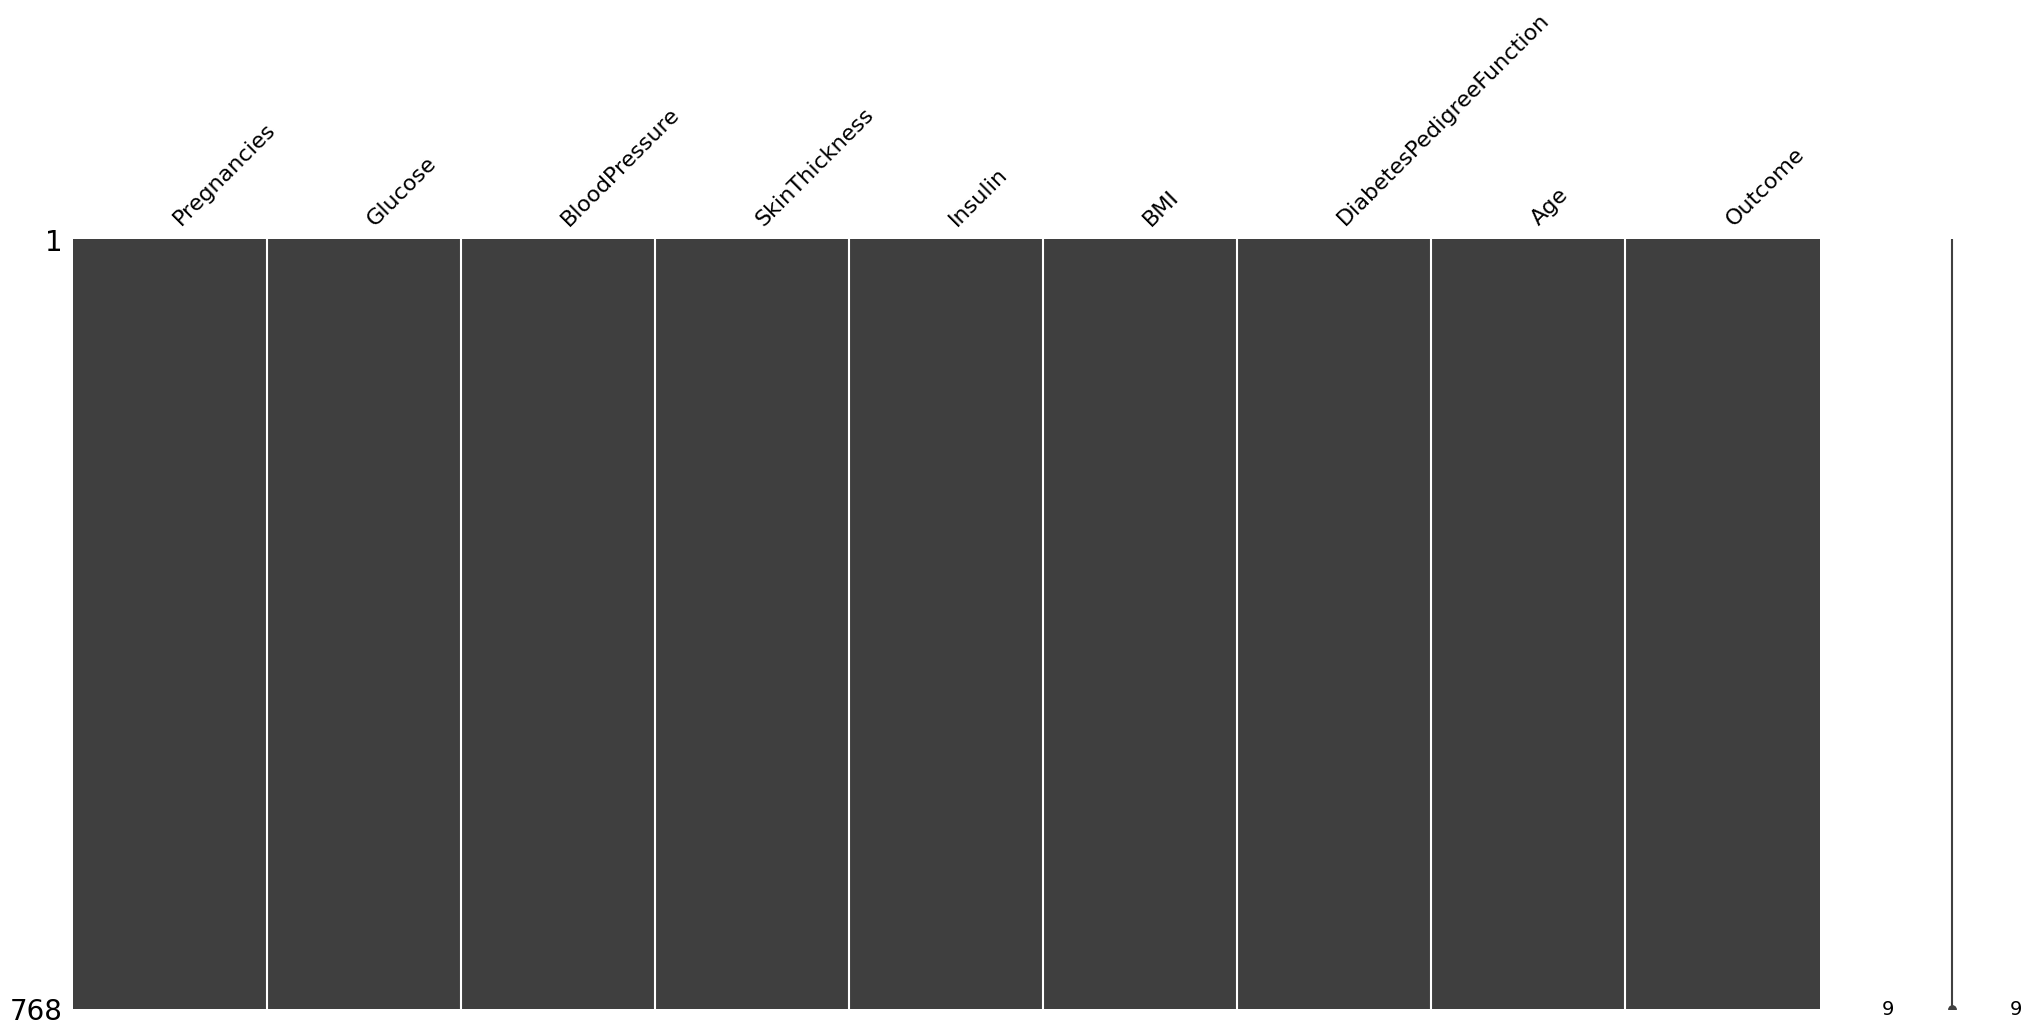

In [3]:
# Checking for missing values
msno.matrix(df)
plt.show()

No Mission values can be seen

### Zero values

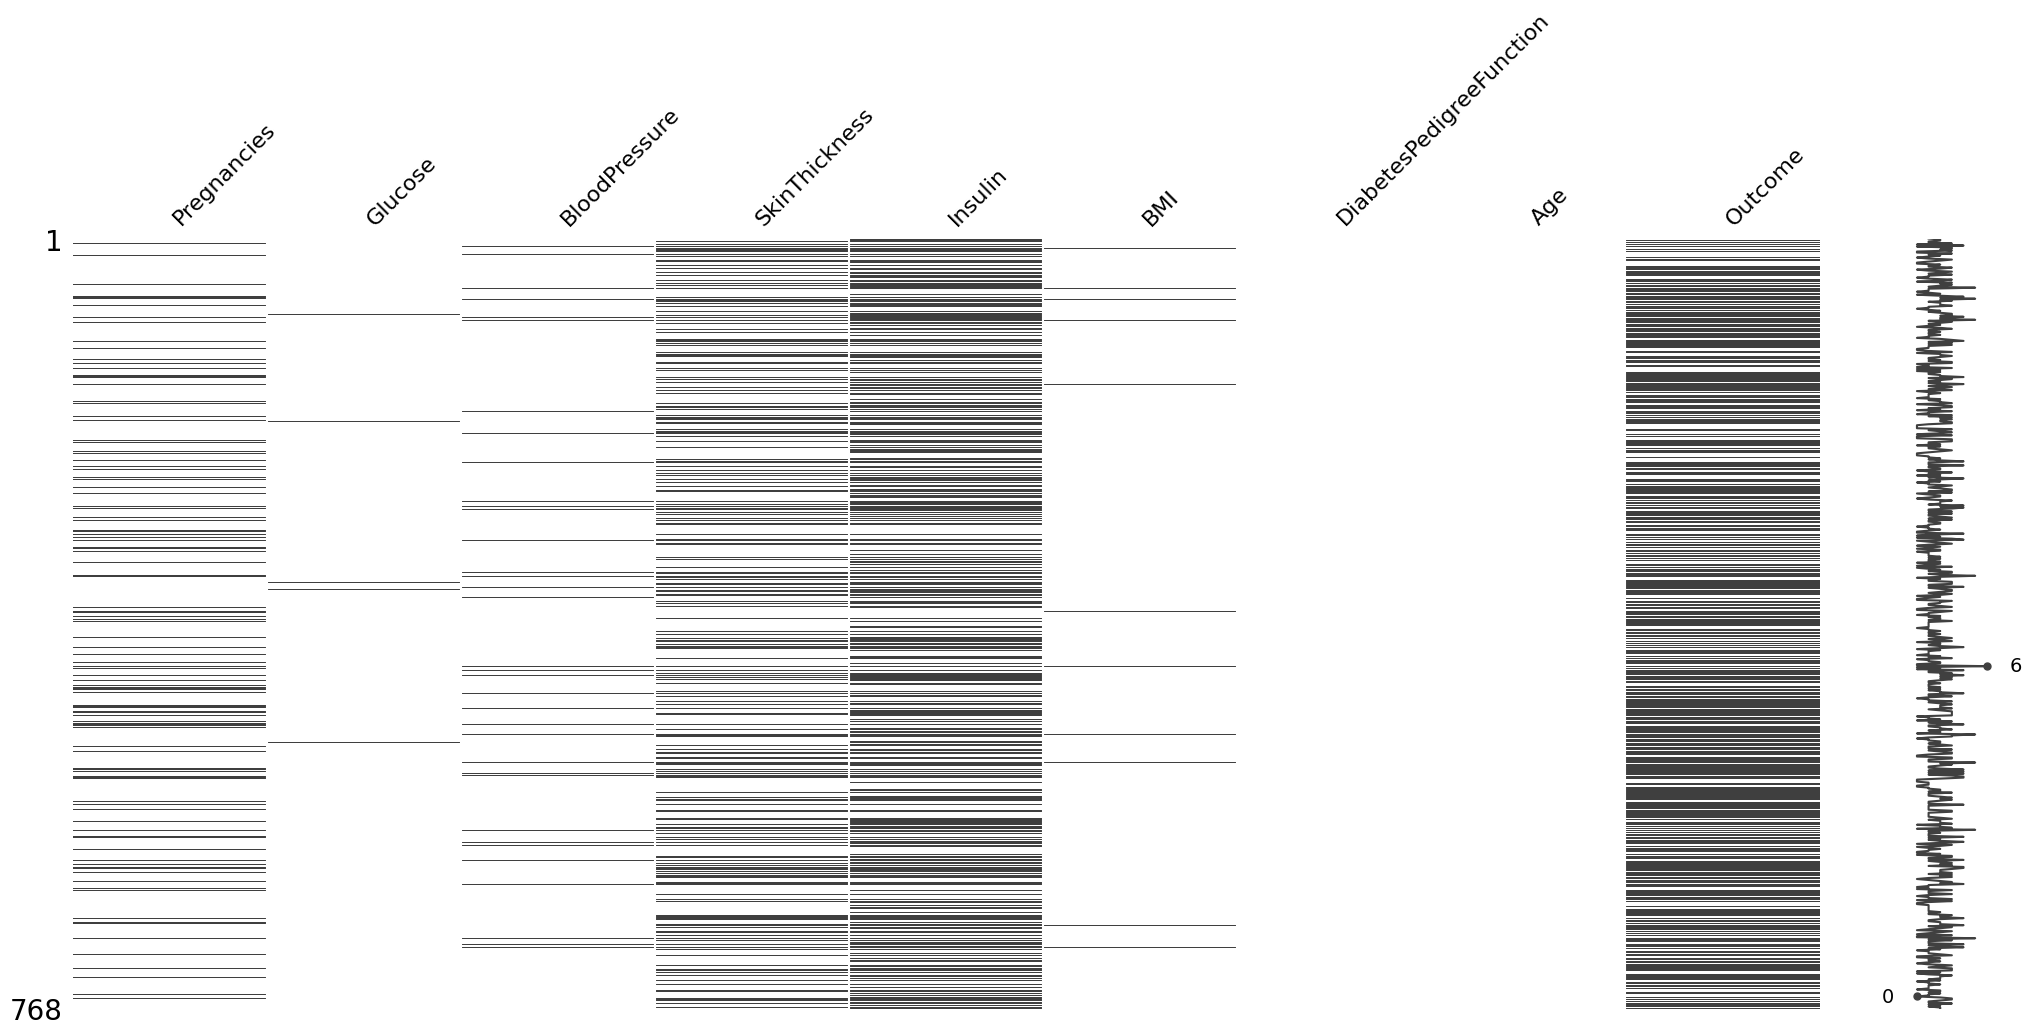

In [4]:
# checking for zero values
msno.matrix(df[df.eq(0)])
plt.show()

The matrix plot above highlights a significant number of zero values in our dataset. While it's normal for variables like "pregnancies" and "outcome" to have zeros, we need to investigate further to understand the possible ranges for each column better. For instance, having a BMI or blood pressure of zero is highly unlikely and needs closer attention.

In [5]:
# Checking for number of 0s in each column
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

It is evident from the print above that Glucose and BMI have only 16 instances of zero values. Given the low occurrence, we'll simply remove these data points without imputing values. SkinThickness shows 227 instances of zero values, which, considering it's measured in millimeters, could potentially be due to rounding of Micrometer measurements. Therefore, we'll retain these values as zero and assess model performance later. However, for Insulin and BloodPressure, we'll employ imputation using various methods. The choice of imputation method will be evaluated based on model performance.

### Null Values

In [6]:
# Cheking for Null Values
df[df.isna()].sum()

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

In [7]:
#  Cheking for Duplicate Values
df.duplicated().sum()

0

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


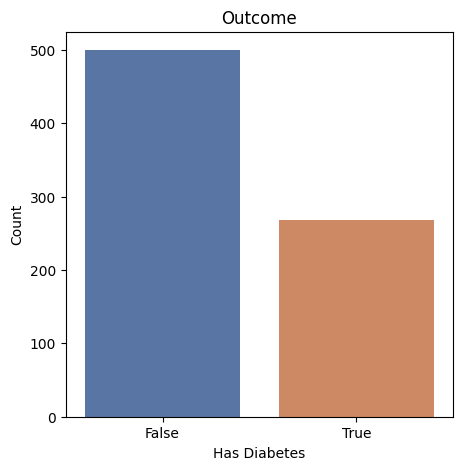

In [9]:
plt.figure(figsize=(5, 5))
sns.countplot(x='Outcome', hue='Outcome', data=df, palette='deep', legend=False)
plt.title("Outcome")
plt.xlabel("Has Diabetes")
plt.xticks([0, 1], ('False', 'True'))
plt.ylabel("Count")
plt.show()

The graph indicates an imbalance in our dataset, with a split of 65/35 between classes 0 and 1, respectively. To address this issue, we can implement the following methods:

1. **Resampling Techniques**:
   - **Over-sampling**: Increase the number of minority class samples by duplicating or generating synthetic samples.
   - **Under-sampling**: Decrease the number of majority class samples by randomly removing instances or based on specific criteria.

2. **Generate Synthetic Samples**:
   - Utilize algorithms like Synthetic Minority Over-sampling Technique (SMOTE) to create synthetic samples for the minority class.

3. **Class Weights**:
   - Adjust the weights assigned to minority class samples during model training. This strategy penalizes misclassifications in the minority class more heavily than those in the majority class.


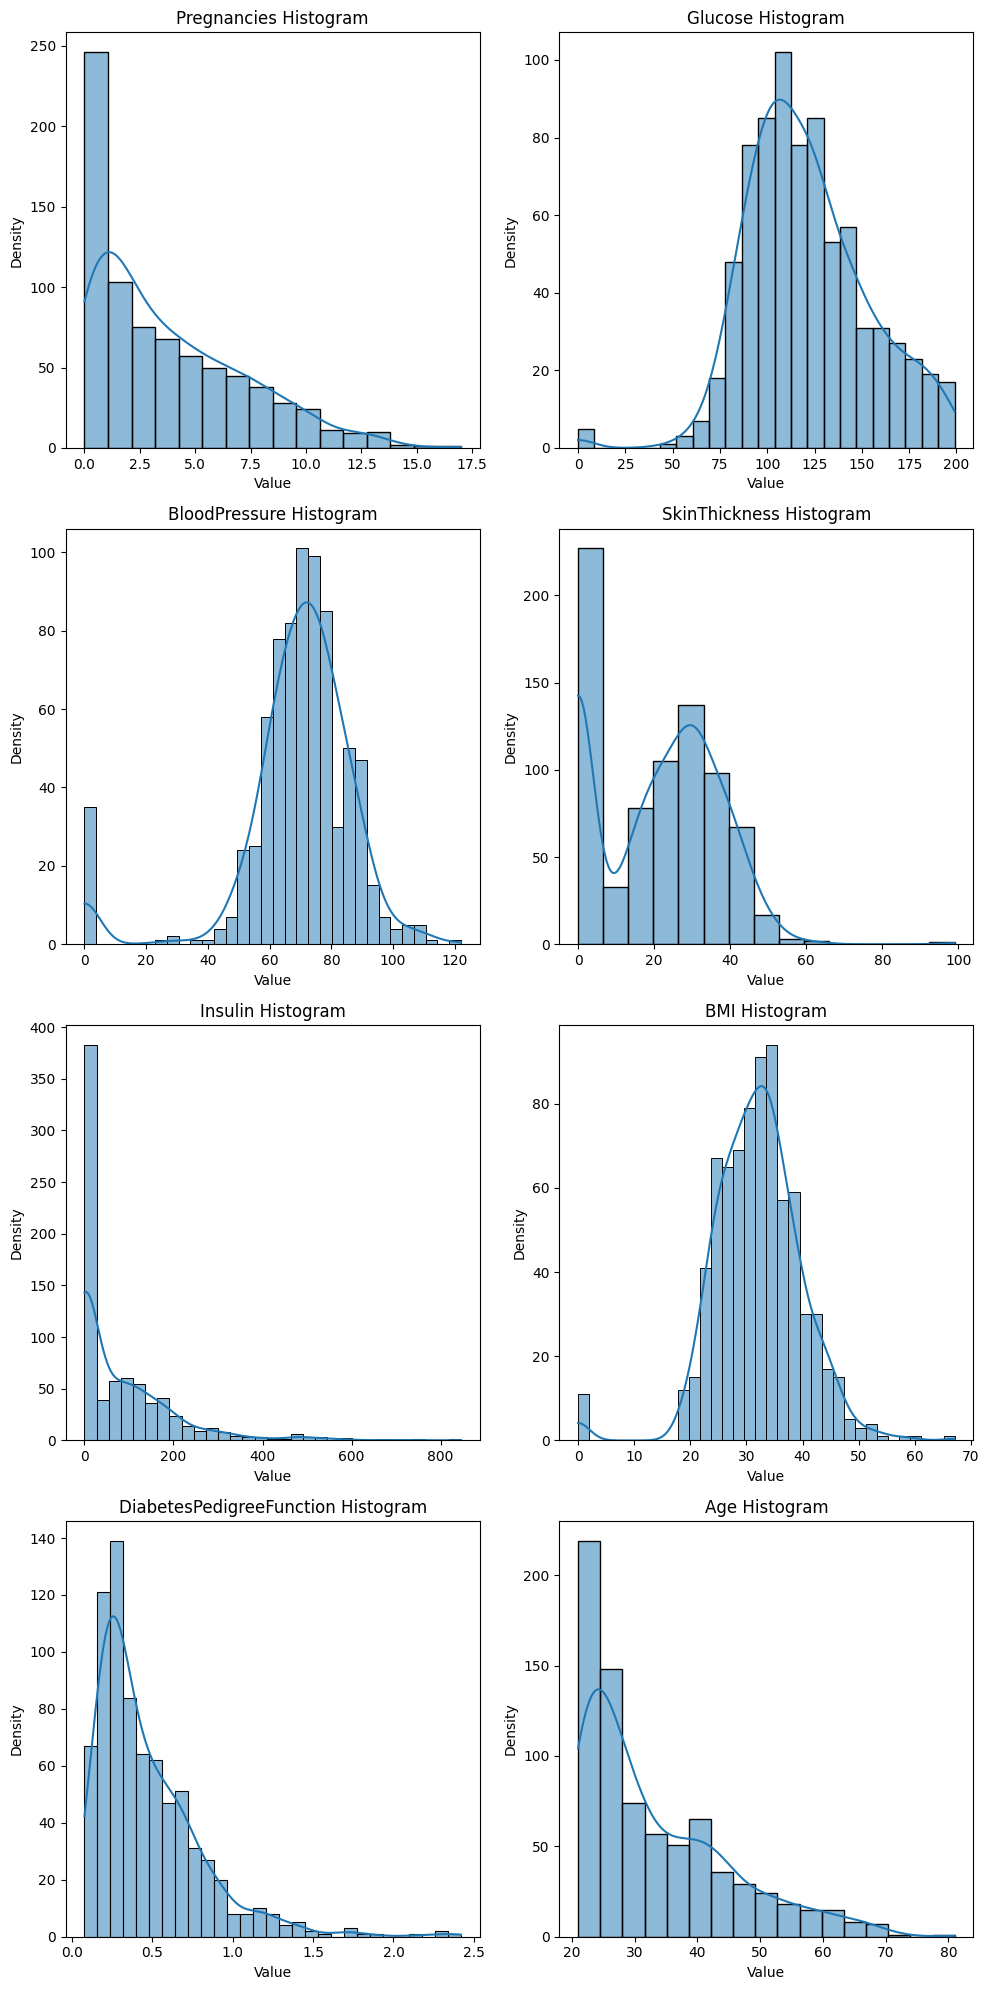

In [10]:
# Determine the layout of subplots based on the number of columns
num_cols = len(df.columns)-2
num_rows = (num_cols + 1) // 2

# Create subplots using seaborn
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

# Plot histograms for all columns
for i, column in enumerate(df.columns[:8]):
    row = i // 2
    col = i % 2
    sns.histplot(df[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column + " Histogram")
    axes[row, col].set_xlabel("Value")
    axes[row, col].set_ylabel("Density")

# Adjust layout
plt.tight_layout()
plt.show()

## Data Imputation



### insulin
While extremely low levels of 2-hour serum insulin are uncommon, it's theoretically possible for someone to have a 2-hour serum insulin level of 0 𝜇𝑈/𝑚𝑙. In most cases, even during fasting, the body secretes a certain amount of insulin to maintain basal metabolic functions. Therefore, while a 2-hour serum insulin level of 0 is possible, it would be unusual and might warrant further investigation to rule out potential underlying conditions or measurement errors. We will allow 0 insulin values for individuals with diabetes as it is possible to have 0 insuling in type 1 diabetes(With type 1 diabetes, beta cells produce little or no insulin).

### Blood Pressure

extremely low readings below 50 mmHg would be concerning and could indicate compromised cardiovascular function.





In [11]:
# Replacing 0 values with Nan

df.loc[df['BloodPressure'] < 50, 'BloodPressure'] = np.NAN
df.loc[(df.Insulin == 0) & (df.Outcome == 0 ),"Insulin"] = np.NAN  # only replacing 0 insulin values for non diabetics

## Value Imputation with regression model

In [12]:
cleaned_df = df[(df.Glucose !=0) & (df.BMI !=0)] # removing data points where Glucose and BMI are non zero

imputed_data = regression_imputation(cleaned_df, 'BloodPressure', ['Age', 'Glucose', 'BMI'])
imputed_data_Blood = combine_imputed_column(imputed_data, 'BloodPressure')
imputed_data_Ins = regression_imputation(imputed_data_Blood, 'Insulin', ['Age', 'Glucose', 'BMI'])
imputed_data_cleaned = combine_imputed_column(imputed_data_Ins, 'Insulin')
imputed_data_cleaned.loc[imputed_data_cleaned.Insulin <0,"Insulin"] = 0


c:\Users\amoha\Pima-Indians-Diabetes\utils.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data.loc[:, target_column + '_imputed'] = model.predict(missing_data_X)
c:\Users\amoha\Pima-Indians-Diabetes\utils.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data.loc[:, target_column + '_imputed'] = model.predict(missing_data_X)


In [13]:
(imputed_data_cleaned == 0 ).sum()

Pregnancies                 108
Glucose                       0
BloodPressure                 0
SkinThickness               218
Insulin                     135
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     488
dtype: int64

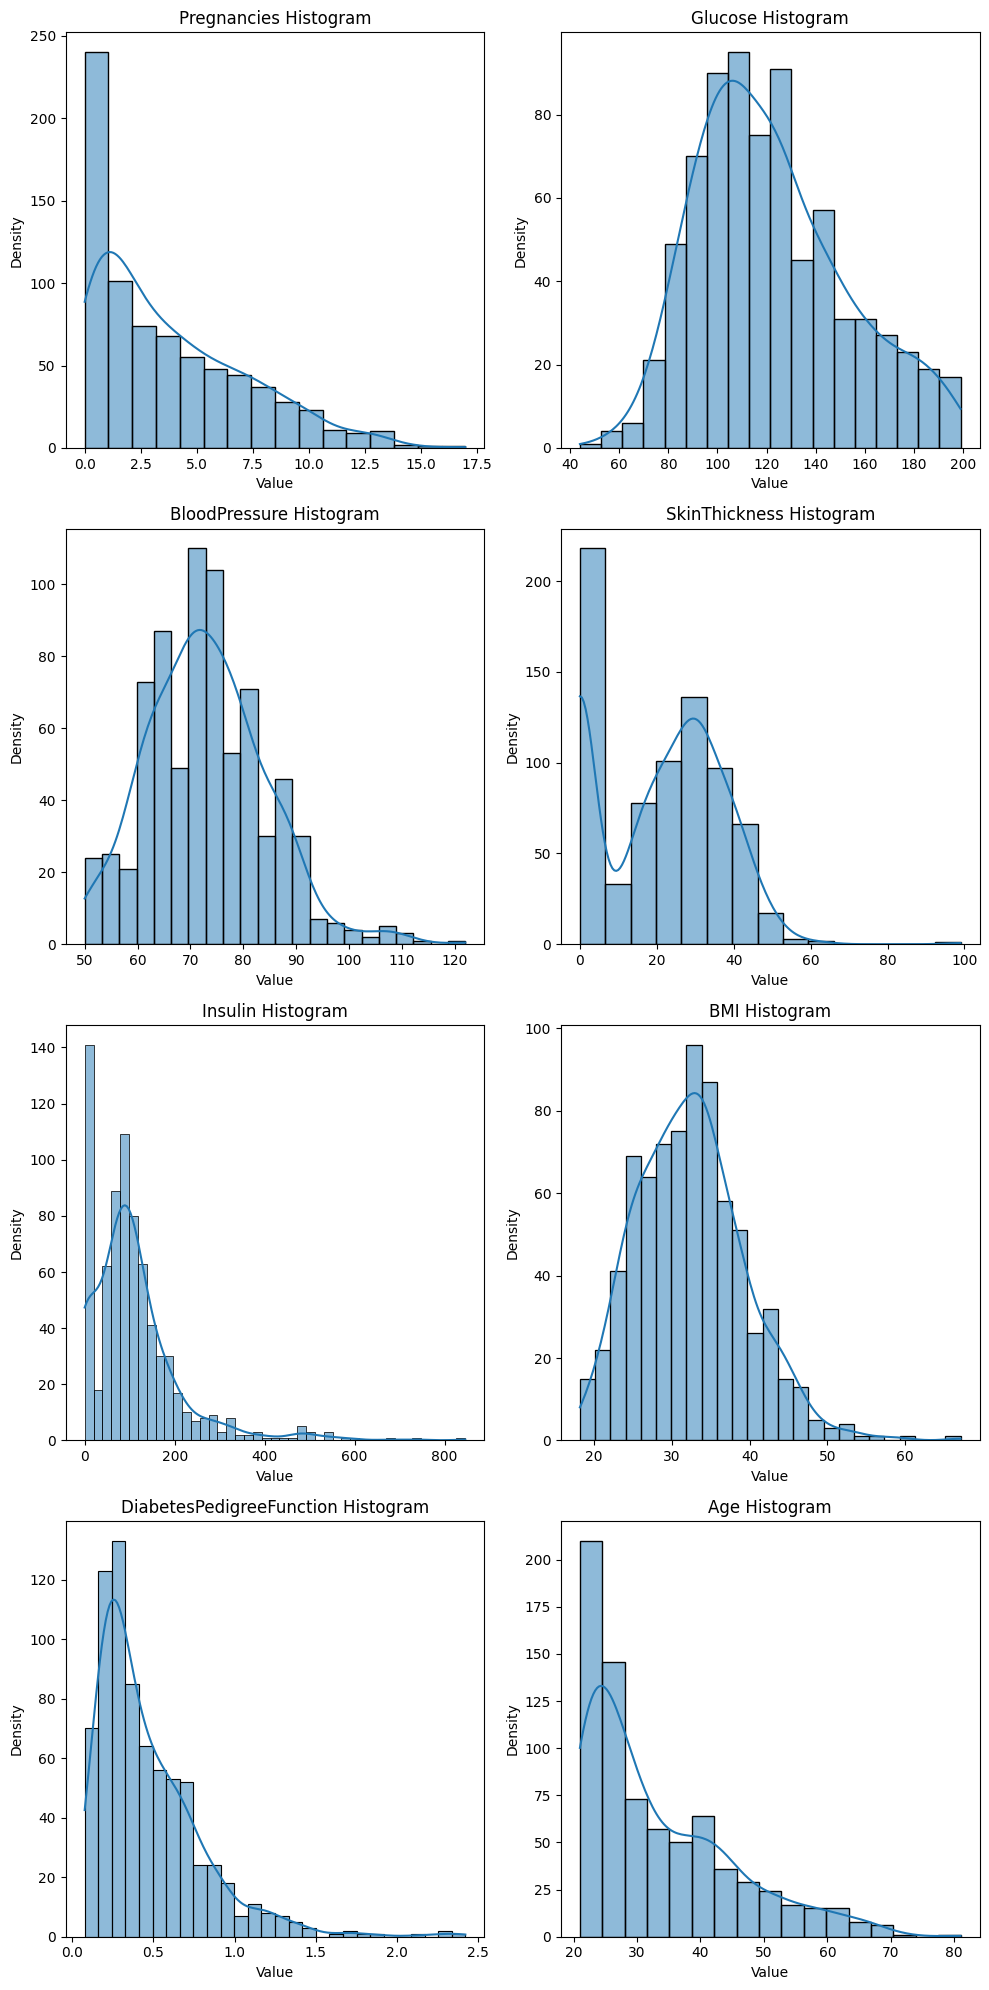

In [14]:
# Determine the layout of subplots based on the number of columns
num_cols = len(imputed_data_cleaned.columns)-2
num_rows = (num_cols + 1) // 2

# Create subplots using seaborn
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

# Plot histograms for all columns
for i, column in enumerate(imputed_data_cleaned.columns[:8]):
    row = i // 2
    col = i % 2
    sns.histplot(imputed_data_cleaned[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column + " Histogram")
    axes[row, col].set_xlabel("Value")
    axes[row, col].set_ylabel("Density")

# Adjust layout
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

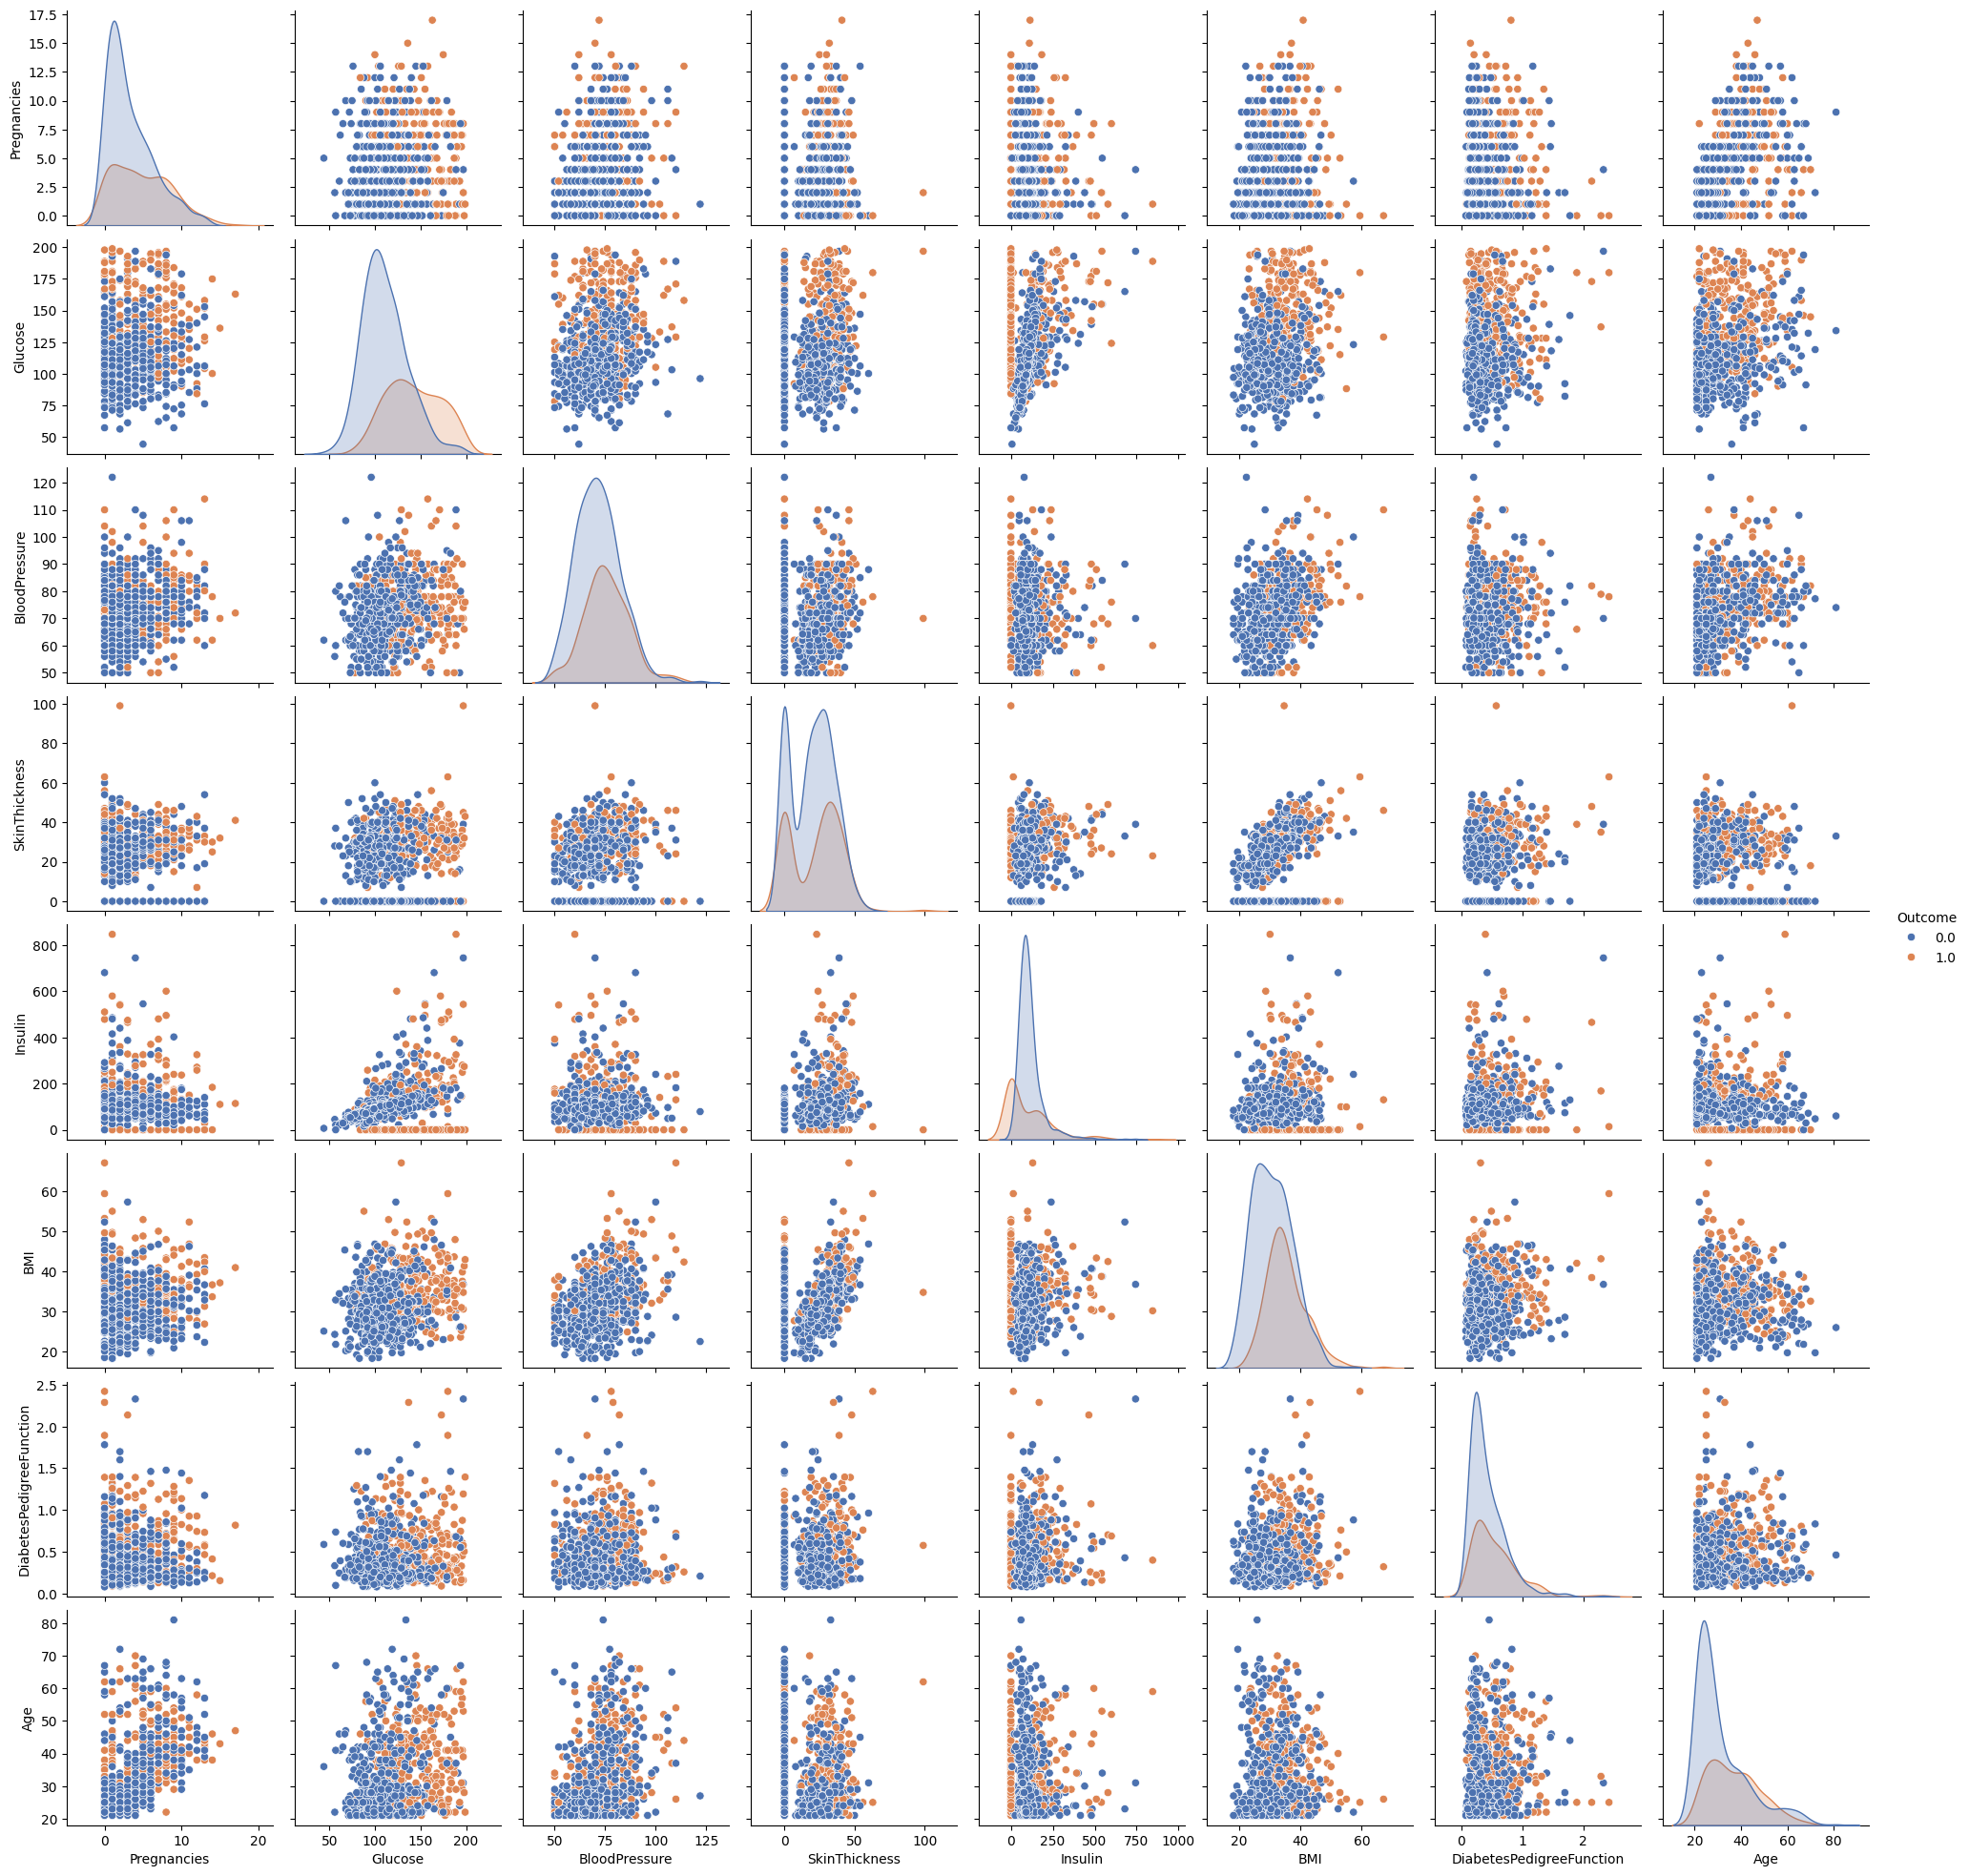

In [15]:
plt.figure(figsize=(10, 10))
sns.pairplot(
    imputed_data_cleaned,
    hue =cols[-1],
    vars=cols[:8],
    diag_kind='kde',
    palette='deep'
)
plt.show()

The above plot shows a huge amount of data from our dataset. the areas of interest are the graphs where there is a clear distinction between people with and without diabetes. As can be seen, the variables dont seem to have any correlation to one another. Some clumping  can be seen in some of the graph, drawing a distinction between the two groups.

### Correlation Between Variables

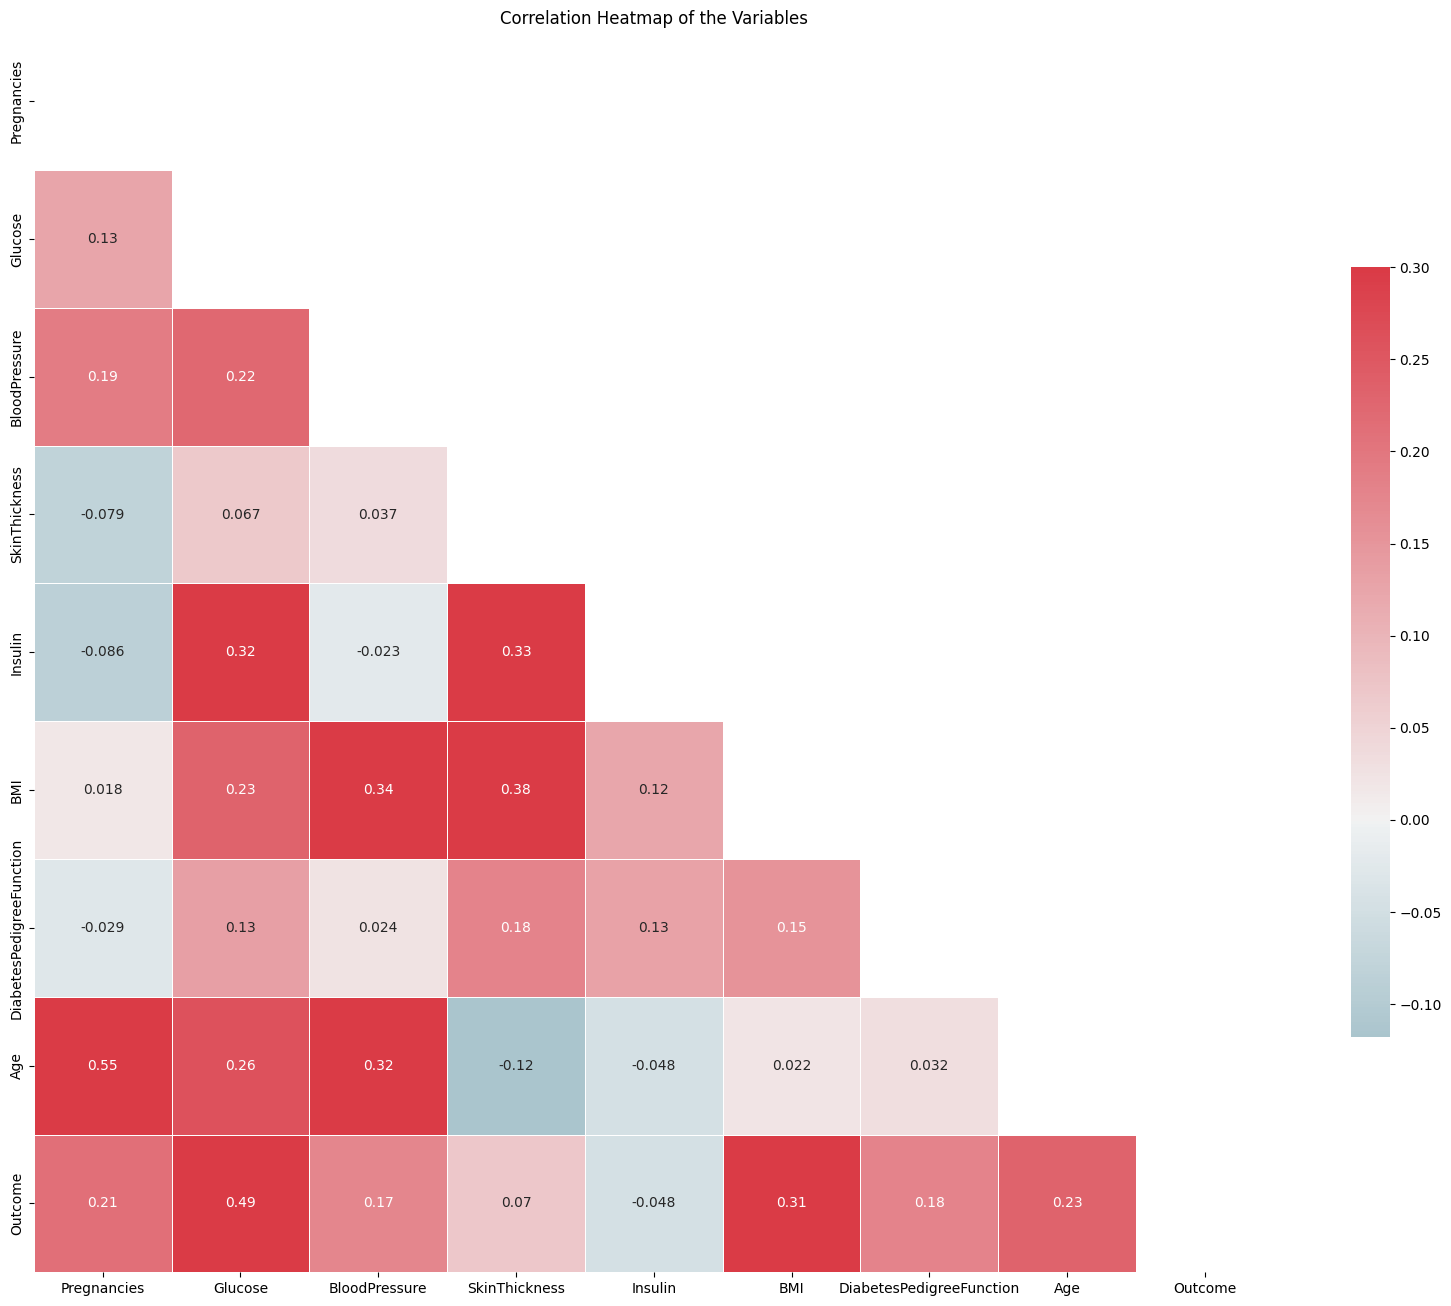

In [16]:
# Computer correlation matrix
corr = imputed_data_cleaned.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colourmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5},
    annot=True
)

ax.set_title('Correlation Heatmap of the Variables')

plt.show()

The plot depicted above suggests that, on the whole, there is minimal correlation among the variables. Notably, Age and Pregnancies show the highest correlation of 0.54, while Glucose exhibits the strongest correlation with the Outcome at 0.47. Nevertheless, certain correlations are discernible, prompting a deeper investigation into specific variable pairs.

### Radar Plots

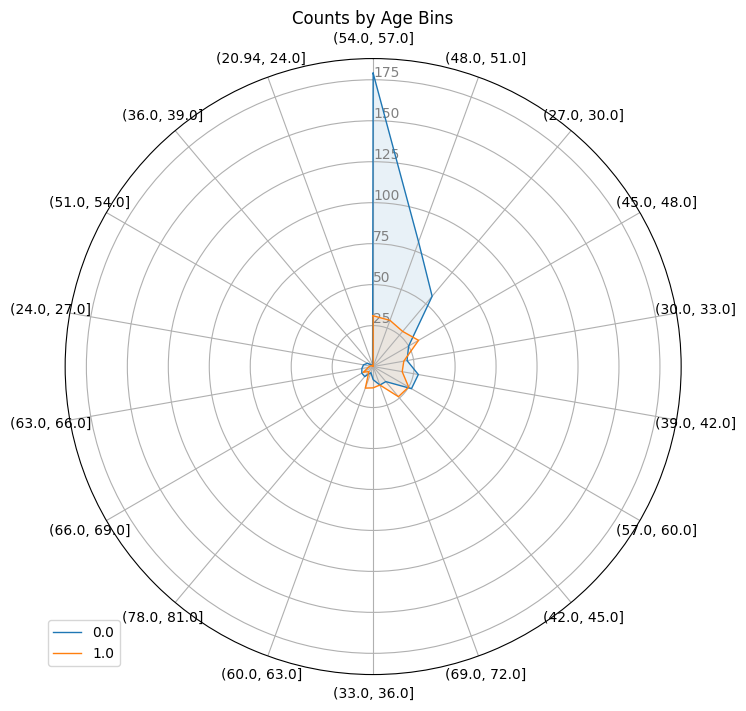

In [17]:
plot_radar(imputed_data_cleaned, 20, "Age","Outcome")

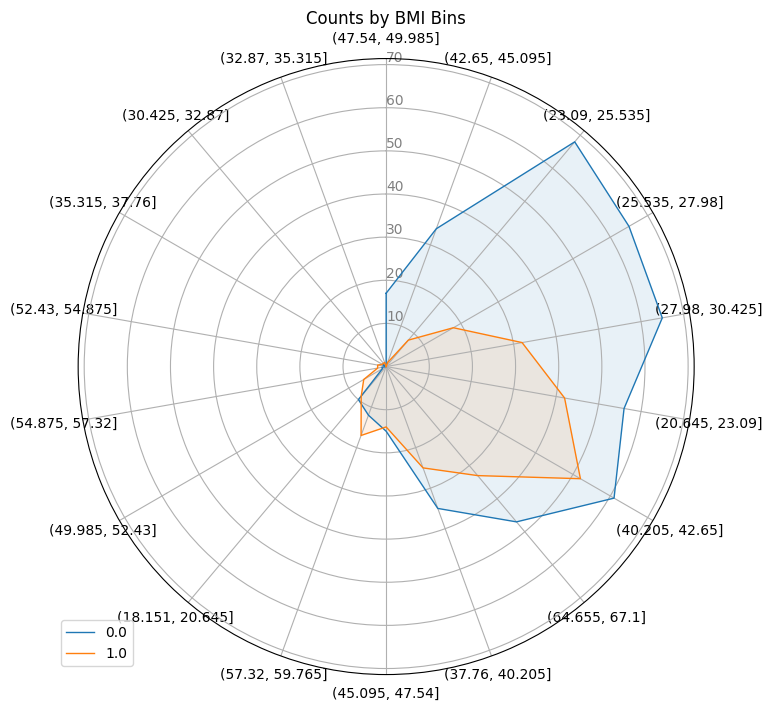

In [18]:
plot_radar(imputed_data_cleaned, 20, "BMI","Outcome")

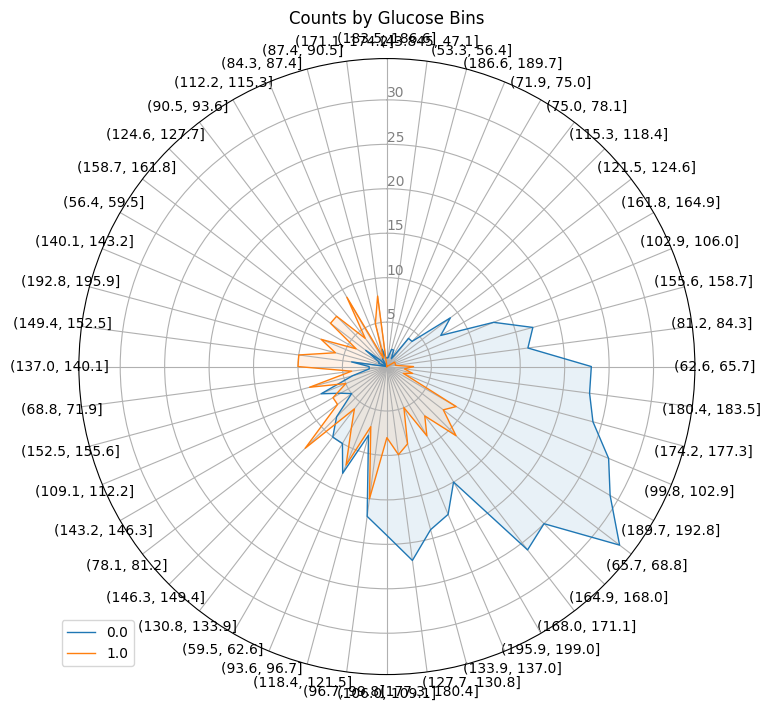

In [19]:
plot_radar(imputed_data_cleaned, 50, "Glucose","Outcome")

The radar plots above are intended to highlight potential differences between the two classes based on the  highest correlated features to outcome. However, they do not clearly reveal any discernible distinctions between the classes.

## Outliers

### IQR method:

The Interquartile Range (IQR) method, a widely employed statistical technique, serves the purpose of identifying outliers within our dataset. By calculating the range between the first quartile (25th percentile) and the third quartile (75th percentile), this method delves into the central tendency of the data while simultaneously assessing its spread. Outliers, which fall beyond a certain range determined by the IQR, are flagged as potential anomalies.

#### Columns Suitable for Outlier Detection:

1. **Glucose**: Glucose levels are continuous and can vary widely, making them suitable for outlier detection. Extreme glucose values may indicate measurement errors or unusual physiological conditions, which are worth investigating.

2. **BloodPressure**: Blood pressure values also vary widely but typically fall within a certain range. Extreme values could signal measurement errors or health issues, making this column suitable for outlier detection.

3. **Insulin**: Like glucose, insulin levels can vary widely. Outliers in insulin levels may be indicative of measurement errors or physiological abnormalities, warranting further investigation.

4. **BMI**: Body Mass Index (BMI) typically ranges within certain limits based on physiological norms. Extreme values may indicate errors or unusual conditions such as severe obesity or malnutrition, making BMI suitable for outlier detection.

#### Columns Less Suitable for Outlier Detection:

1. **Pregnancies**: While pregnancies are discrete whole numbers, extreme values might not necessarily indicate outliers. The interpretation of outliers in pregnancies could be subjective and context-dependent, making it less suitable for outlier detection using the IQR method.

2. **SkinThickness**: Skin thickness might have a more defined range compared to other variables. Extreme values here could be outliers, but the definition of an outlier would depend on the context and the population being studied. Skin thickness may require additional domain knowledge for accurate outlier detection.

3. **DiabetesPedigreeFunction**: The diabetes pedigree function is a score derived from family history and might not have a clear upper or lower limit. Outliers here could be indicative of unusual family histories or data entry errors. The interpretation of outliers in this column may be less straightforward and may require additional context beyond the IQR method.

4. **Age**: While age generally has a defined range, outliers may still exist, particularly if the dataset includes individuals at the extremes of age or if there are data entry errors. Age may require additional considerations beyond the IQR method for accurate outlier detection, such as the demographic characteristics of the population being studied.


In [20]:
outliers_cols = ["Glucose","BloodPressure","Insulin","BMI"]
outliers_df = pd.DataFrame()

for col in outliers_cols:
    stats = imputed_data_cleaned[col].describe()
    
    IQR = stats['75%'] - stats['25%']
    upper_limit = stats['75%'] + 1.5 * IQR
    lower_limit = stats['25%'] - 1.5 * IQR
    
    outliers = imputed_data_cleaned[(imputed_data_cleaned[col] > upper_limit) | (imputed_data_cleaned[col] < lower_limit)]

    if  outliers.empty:
        print(f'\n No outlier found in: {col}')
    else:
        print(f'\n -------------- {col} --------------')
        outliers_df = pd.concat([outliers_df, outliers])
    print(f"Number of Outliers: {len(outliers)}")
    print(f'\n IQR: {IQR}')
    print(f'\n Outliers Lower Bound: {lower_limit}')
    print(f'\n Outliers Upper Bound: {upper_limit}')

print(f'Total number of outlier: {len(outliers_df)}')


 No outlier found in: Glucose
Number of Outliers: 0

 IQR: 41.25

 Outliers Lower Bound: 37.875

 Outliers Upper Bound: 202.875

 -------------- BloodPressure --------------
Number of Outliers: 12

 IQR: 15.192707879896531

 Outliers Lower Bound: 42.01823030025867

 Outliers Upper Bound: 102.78906181984479

 -------------- Insulin --------------
Number of Outliers: 47

 IQR: 90.43013073330812

 Outliers Lower Bound: -86.21262436705828

 Outliers Upper Bound: 275.50789856617416

 -------------- BMI --------------
Number of Outliers: 8

 IQR: 9.100000000000001

 Outliers Lower Bound: 13.849999999999998

 Outliers Upper Bound: 50.25
Total number of outlier: 67


### Z-Score:

In [23]:
all_outliers = pd.DataFrame()
# Compute mean and standard deviation
for col in outliers_cols:
    mean = df[col].mean()
    std_dev = df[col].std()

    # Calculating z-scores
    df['Z_Score'] = (df[col] - mean) / std_dev

    # outliers threshold 
    threshold = 3

    # Identify outliers
    outliers = df[abs(df['Z_Score']) > threshold]
    all_outliers = pd.concat([all_outliers,outliers])
    
    print(len(outliers),col)
print(f'Total number of outlier: {len(all_outliers)}')


5 Glucose
7 BloodPressure
12 Insulin
14 BMI
Total number of outlier: 38


### Outlier Treatment Strategy 

In this analysis, we will adopt the assumption that outlier values are not due to measurement issues. This assumption is based on the observation that the higher and lower bounds identified using the interquartile range (IQR) method appear to be sensible data points within the context of the features being examined.

**Rationale**

The decision to retain outliers is driven by several factors:

1. **Significant Proportion of Outliers**: Out of the 768 data points in our dataset, 143 have been identified as outliers using the z-score method with a threshold of 2. While this represents a substantial portion of our data, it is essential to recognize that these outliers may contain valuable information that could contribute to the robustness and generalization of our classification model.

2. **Sensible Outlier Bounds**: The outliers identified through the IQR method do not appear to be extreme values that are likely to be inaccurate. Instead, they represent variations in the data that are within reasonable bounds given the nature of the features being analyzed (e.g., glucose levels, blood pressure, insulin levels, BMI).

**Strategy**

Given these considerations, we will proceed with retaining the outliers in our dataset and assess the performance of our classification model. By adopting this approach, we aim to develop a classification model that leverages the full range of information present in our dataset, including the outliers, to achieve accurate and generalizable predictions of diabetes status.

In [22]:
imputed_data_cleaned.to_csv("data/cleaned_df.csv",index=False)
#imputed_df.drop("Z_Score",axis = 1).to_csv("data/imputed_df.csv",index=False)